# <div class='alert alert-block alert-success'>COMP 642 Final Project - Part 2</div>

<div class='alert alert-block alert-info'>
Data:  Prepare a data analysis report that includes:

- Data definition for each parameter including measurement units

- Plan for missing data for each parameter (if needed)

- Plan for additional parameters or data (if needed)

- Any transformations necessary

- Plan for separating

- Visualization of data if possible
</div>

# <div class='alert alert-block alert-success'> Data Definitions </div>

### Summary

We will explore some features and data which will be considered for use in our project. 

It may be best to redefine our goal. We are attempting to determine, based on daily or weekly market close prices of TQQQ, whether the following day or week will yield a gain or a loss. Depending on that, we will decide to long (buy) or short (sell) TQQQ for the upcoming week/day. There are many factors that could influence this. TQQQ is a 3x leveraged ETF of the Nasdaq Composite. Major movements in large cap stocks, mostly centered toward technology stocks, are the major influencers of the price movements in this product. These large cap companies are also heavily influenced by outside economic factors that are not entirely dependent on company performance/financials. Also, there are technical techniques lightly used in the investment industry that may allow more insight into possible future movements of secuirty prices. These techniques are related to historical price movements and trade volumes. Armed with this observation, we can make some general assumptions for data required for our analysis and our model.

---

1. Macro market factors that influence stock prices
    - Interest rates
    - Inflation
    - Currency
    - Market Volitility (Fear Gauge)
    - Commodities

2. Technical Indicators
    - 35 day price exponential moving average
    - 200 day price moving average
    - Volume
    - Moving Average Convergence Divergence (MACD)
    - Relative Strength Index (RSI)

---

### Macro Market Data

We will be using some readily available ETF data which tracks each of these macro economic features. 

**TQQQ ETF*** = 

**Interest Rates** = ProShares Short 20+ Year Treasury ETF: Ticker TBF (stock price & fractional return: dtype - float)

**Inflation** = iShares TIPS Bond ETF: Ticker TIP (stock price & fractional return: dtype - float)

**Currency** = Invesco DB US Dollar Index Bullish Fund: Ticker UUP (stock price & fractional return: dtype - float)

**Market Volitility** =  ProShares VIX Short-Term Futures ETF: Ticker VIXY (stock price & fractional return: dtype - float)

**Commodities** = United States Oil Fund: Ticker USO (stock price & fractional return: dtype - float)

**Commodities** = SPDR Gold Shares: Ticker GLD (stock price & fractional return: dtype - float)

---

### Technical Indicator Data

We will be conducting feature engineering of the daily close price data in order to construct features that make 4 of the indicators;

35 day price exponential moving average: ema_35 (average price: dtype - float)

200 day simple moving average: sma_200 (average price: dtype - float)

Moving Average Convergence Divergence (MACD): macd (price fraction: dtype - float)

Relative Strength Index (RSI): rsi (average price: dtype - float)

We will also track purchase volume (vol) and we may need to convert the price data into percentages gained or loss from the previous day close depending on how we would like to visualize the data and/or make predictions.

--- 

Finally we will feature engineer our dependent variable. This depending variable will be the next day/week closing price. We will also create a binary categorical variable to indicate long or short depending on if the next day/week closing price is greater than the current day/week closing price

In [2]:
# import required packages
# !pip3 install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Upload Data

We will start by uploading the required data as defined by the above information.

In [3]:
# fetching daily adjusted close price, volume, and percent changes
tqqq_price = yf.download('TQQQ', start='2010-12-31', end='2024-02-29', group_by='ticker')[['Adj Close', 'Volume']]
tqqq_price['tqqq_ret'] = tqqq_price['Adj Close'].pct_change()
tqqq_price.rename(columns={'Adj Close': 'tqqq_close', 'Volume': 'tqqq_volume'}, inplace=True)

tbf_price = pd.DataFrame(yf.download('TBF', start='2010-12-31', end='2024-02-29')[['Adj Close', 'Volume']])
tbf_price['tbf_ret'] = tbf_price['Adj Close'].pct_change()
tbf_price.rename(columns={'Adj Close': 'tbf_close', 'Volume': 'tbf_volume'}, inplace=True)

tip_price = pd.DataFrame(yf.download('TIP', start='2010-12-31', end='2024-02-29')[['Adj Close', 'Volume']])
tip_price['tip_ret'] = tip_price['Adj Close'].pct_change()
tip_price.rename(columns={'Adj Close': 'tip_close', 'Volume': 'tip_volume'}, inplace=True)

uup_price = pd.DataFrame(yf.download('UUP', start='2010-12-31', end='2024-02-29')[['Adj Close', 'Volume']])
uup_price['uup_ret'] = uup_price['Adj Close'].pct_change()
uup_price.rename(columns={'Adj Close': 'uup_close', 'Volume': 'uup_volume'}, inplace=True)

vixy_price = pd.DataFrame(yf.download('VIXY', start='2010-12-31', end='2024-02-29')[['Adj Close', 'Volume']])
vixy_price['vixy_ret'] = vixy_price['Adj Close'].pct_change()
vixy_price.rename(columns={'Adj Close': 'vixy_close', 'Volume': 'vixy_volume'}, inplace=True)

uso_price = pd.DataFrame(yf.download('USO', start='2010-12-31', end='2024-02-29')[['Adj Close', 'Volume']])
uso_price['uso_ret'] = uso_price['Adj Close'].pct_change()
uso_price.rename(columns={'Adj Close': 'uso_close', 'Volume': 'uso_volume'}, inplace=True)

gld_price = pd.DataFrame(yf.download('GLD', start='2010-12-31', end='2024-02-29')[['Adj Close', 'Volume']])
gld_price['gld_ret'] = gld_price['Adj Close'].pct_change()
gld_price.rename(columns={'Adj Close': 'gld_close', 'Volume': 'gld_volume'}, inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# joining all data into a single dataframe according to the index (date)
df = pd.merge(tqqq_price, tbf_price, left_index=True, right_index=True)
df = pd.merge(df, tip_price, left_index=True, right_index=True)
df = pd.merge(df, uup_price, left_index=True, right_index=True)
df = pd.merge(df, vixy_price, left_index=True, right_index=True)
df = pd.merge(df, uso_price, left_index=True, right_index=True)
df = pd.merge(df, gld_price, left_index=True, right_index=True)
df.reset_index(inplace=True)
df.head()

,Date,tqqq_close,tqqq_volume,tqqq_ret,tbf_close,tbf_volume,tbf_ret,tip_close,tip_volume,tip_ret,...,uup_ret,vixy_close,vixy_volume,vixy_ret,uso_close,uso_volume,uso_ret,gld_close,gld_volume,gld_ret
0,2011-01-04,0.784261,65760000,-0.001553,40.865879,272600,-0.000226,77.868210,1049900,0.002521,...,0.002629,158460.0,56,NaN,304.640015,1758150,-0.024840,134.750000,26154300,-0.023551
1,2011-01-05,0.803726,61440000,0.024819,41.751659,402500,0.021675,77.570801,869400,-0.003819,...,0.010053,155100.0,37,-0.021204,308.160004,1582125,0.011555,134.369995,16700900,-0.002820
2,2011-01-06,0.810993,52262400,0.009042,41.576344,463800,-0.004199,77.795692,827900,0.002899,...,0.007789,155760.0,42,0.004255,301.440002,1399413,-0.021807,133.830002,15965300,-0.004019
3,2011-01-07,0.809113,76204800,-0.002319,41.373363,599800,-0.004882,78.042297,979300,0.003170,...,0.003006,156080.0,22,0.002054,301.359985,1025713,-0.000265,133.580002,16761400,-0.001868
4,2011-01-10,0.818210,43027200,0.011243,41.133461,654800,-0.005798,78.267204,639600,0.002882,...,-0.003425,155760.0,35,-0.002050,305.359985,980450,0.013273,134.119995,8429900,0.004042


## Plotting Behavior

As part of understanding our data, we will review some of the price, volume and daily return behavior for each of the secirities under investigation.

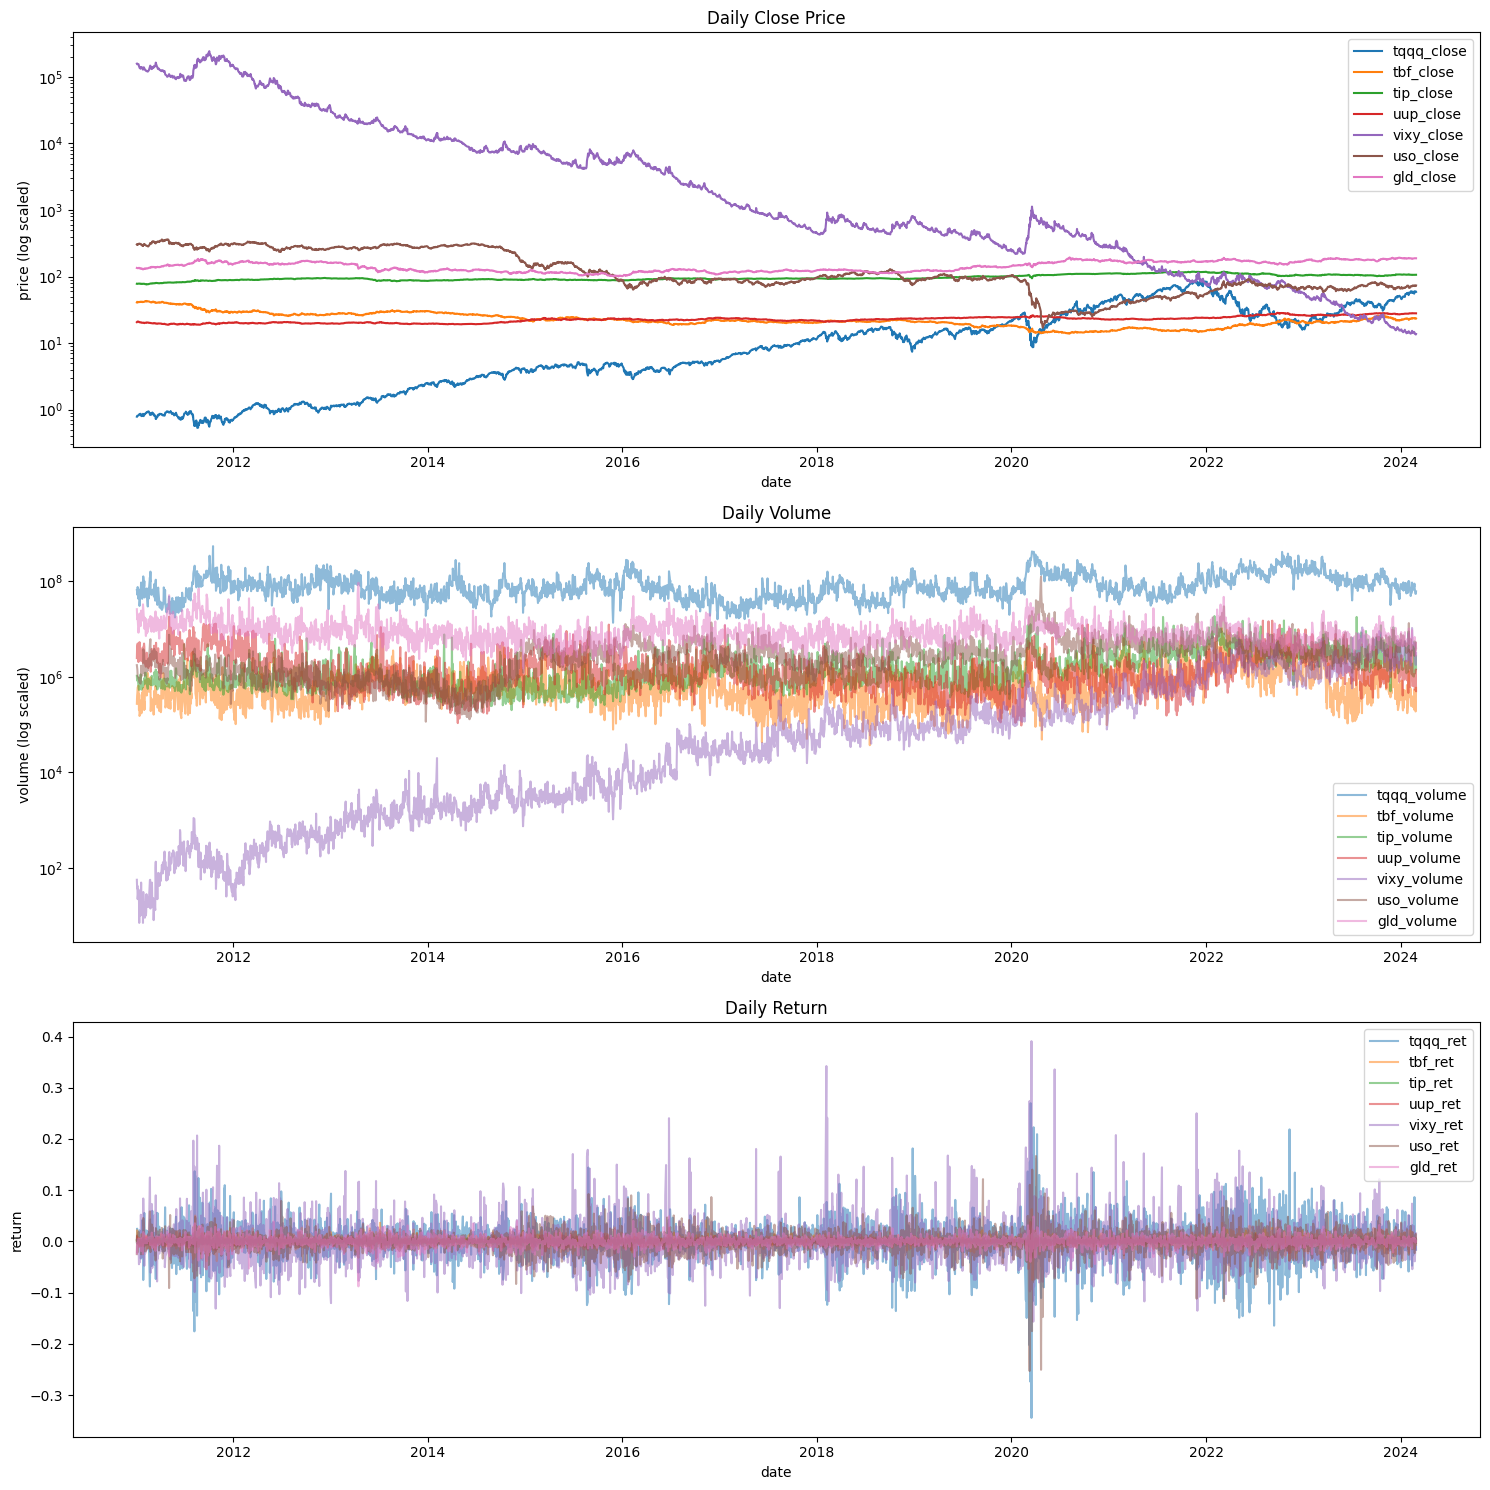

In [5]:
# plotting the daily price movement features
fig, axes = plt.subplots(3, 1, figsize=(15,15))

axes[0].plot(df.Date, df.tqqq_close, label=df.tqqq_close.name)
axes[0].plot(df.Date, df.tbf_close, label=df.tbf_close.name)
axes[0].plot(df.Date, df.tip_close, label=df.tip_close.name)
axes[0].plot(df.Date, df.uup_close, label=df.uup_close.name)
axes[0].plot(df.Date, df.vixy_close, label=df.vixy_close.name)
axes[0].plot(df.Date, df.uso_close, label=df.uso_close.name)
axes[0].plot(df.Date, df.gld_close, label=df.gld_close.name)
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_title('Daily Close Price')
axes[0].set_ylabel('price (log scaled)')
axes[0].set_xlabel('date')

axes[1].plot(df.Date, df.tqqq_volume, label=df.tqqq_volume.name, alpha=0.5)
axes[1].plot(df.Date, df.tbf_volume, label=df.tbf_volume.name, alpha=0.5)
axes[1].plot(df.Date, df.tip_volume, label=df.tip_volume.name, alpha=0.5)
axes[1].plot(df.Date, df.uup_volume, label=df.uup_volume.name, alpha=0.5)
axes[1].plot(df.Date, df.vixy_volume, label=df.vixy_volume.name, alpha=0.5)
axes[1].plot(df.Date, df.uso_volume, label=df.uso_volume.name, alpha=0.5)
axes[1].plot(df.Date, df.gld_volume, label=df.gld_volume.name, alpha=0.5)
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_title('Daily Volume')
axes[1].set_ylabel('volume (log scaled)')
axes[1].set_xlabel('date')

axes[2].plot(df.Date, df.tqqq_ret, label=df.tqqq_ret.name, alpha=0.5)
axes[2].plot(df.Date, df.tbf_ret, label=df.tbf_ret.name, alpha=0.5)
axes[2].plot(df.Date, df.tip_ret, label=df.tip_ret.name, alpha=0.5)
axes[2].plot(df.Date, df.uup_ret, label=df.uup_ret.name, alpha=0.5)
axes[2].plot(df.Date, df.vixy_ret, label=df.vixy_ret.name, alpha=0.5)
axes[2].plot(df.Date, df.uso_ret, label=df.uso_ret.name, alpha=0.5)
axes[2].plot(df.Date, df.gld_ret, label=df.gld_ret.name, alpha=0.5)
axes[2].legend()
axes[2].set_title('Daily Return')
axes[2].set_ylabel('return')
axes[2].set_xlabel('date')

plt.tight_layout()
plt.show()

### Observations

It seems that TQQQ have inverse behavior while the other securities seem to be considerably stable, at least in comparison to TQQQ, with the exception of USO following similar behavior to TQQQ but with a small delay/ reaction to movements in TQQQ.

Volume for GLD has steadily increased over time while the volume for all other securities has remained consistent.

It is difficult to find any significant value from the daily returns chart, there is a lot of noise and movement within each security.

## Feature Engineering

Engineering additional technical indicators that are used as indication tools of momentum in the market. These tools/indicators usually aid the investor determining if securities are overbought or oversold. Although, in practice they are not 100% accurate, they can give some sign or signal to the investor if price action could possibly increase or decrease.

In [6]:
# feature engineering tqqq technical indicator data
# 35-day EMA
df['tqqq_35_day_ema'] = df['tqqq_close'].ewm(span=35, adjust=False).mean()

# Calculate 200-day SMA
df['tqqq_200_day_sma'] = df['tqqq_close'].rolling(window=200).mean()

# Calculate MACD and MACD signal
df['tqqq_macd'] = df['tqqq_close'].ewm(span=12, adjust=False).mean() - df['tqqq_close'].ewm(span=26, adjust=False).mean()
df['tqqq_macd_signal'] = df['tqqq_macd'].ewm(span=9, adjust=False).mean()

# Calculate RSI
delta = df['tqqq_close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['tqqq_rsi'] = 100 - (100 / (1 + rs))
df.fillna(0, inplace=True)
df.head()

,Date,tqqq_close,tqqq_volume,tqqq_ret,tbf_close,tbf_volume,tbf_ret,tip_close,tip_volume,tip_ret,...,uso_volume,uso_ret,gld_close,gld_volume,gld_ret,tqqq_35_day_ema,tqqq_200_day_sma,tqqq_macd,tqqq_macd_signal,tqqq_rsi
0,2011-01-04,0.784261,65760000,-0.001553,40.865879,272600,-0.000226,77.868210,1049900,0.002521,...,1758150,-0.024840,134.750000,26154300,-0.023551,0.784261,0.0,0.000000,0.000000,0.0
1,2011-01-05,0.803726,61440000,0.024819,41.751659,402500,0.021675,77.570801,869400,-0.003819,...,1582125,0.011555,134.369995,16700900,-0.002820,0.785343,0.0,0.001553,0.000311,0.0
2,2011-01-06,0.810993,52262400,0.009042,41.576344,463800,-0.004199,77.795692,827900,0.002899,...,1399413,-0.021807,133.830002,15965300,-0.004019,0.786768,0.0,0.003331,0.000915,0.0
3,2011-01-07,0.809113,76204800,-0.002319,41.373363,599800,-0.004882,78.042297,979300,0.003170,...,1025713,-0.000265,133.580002,16761400,-0.001868,0.788009,0.0,0.004537,0.001639,0.0
4,2011-01-10,0.818210,43027200,0.011243,41.133461,654800,-0.005798,78.267204,639600,0.002882,...,980450,0.013273,134.119995,8429900,0.004042,0.789687,0.0,0.006155,0.002542,0.0


## Plotting New Features

### Technical Indicators

Here, we will be plotting the behvaior of these features to determine the understanding of their behavior with the price movement of TQQQ.

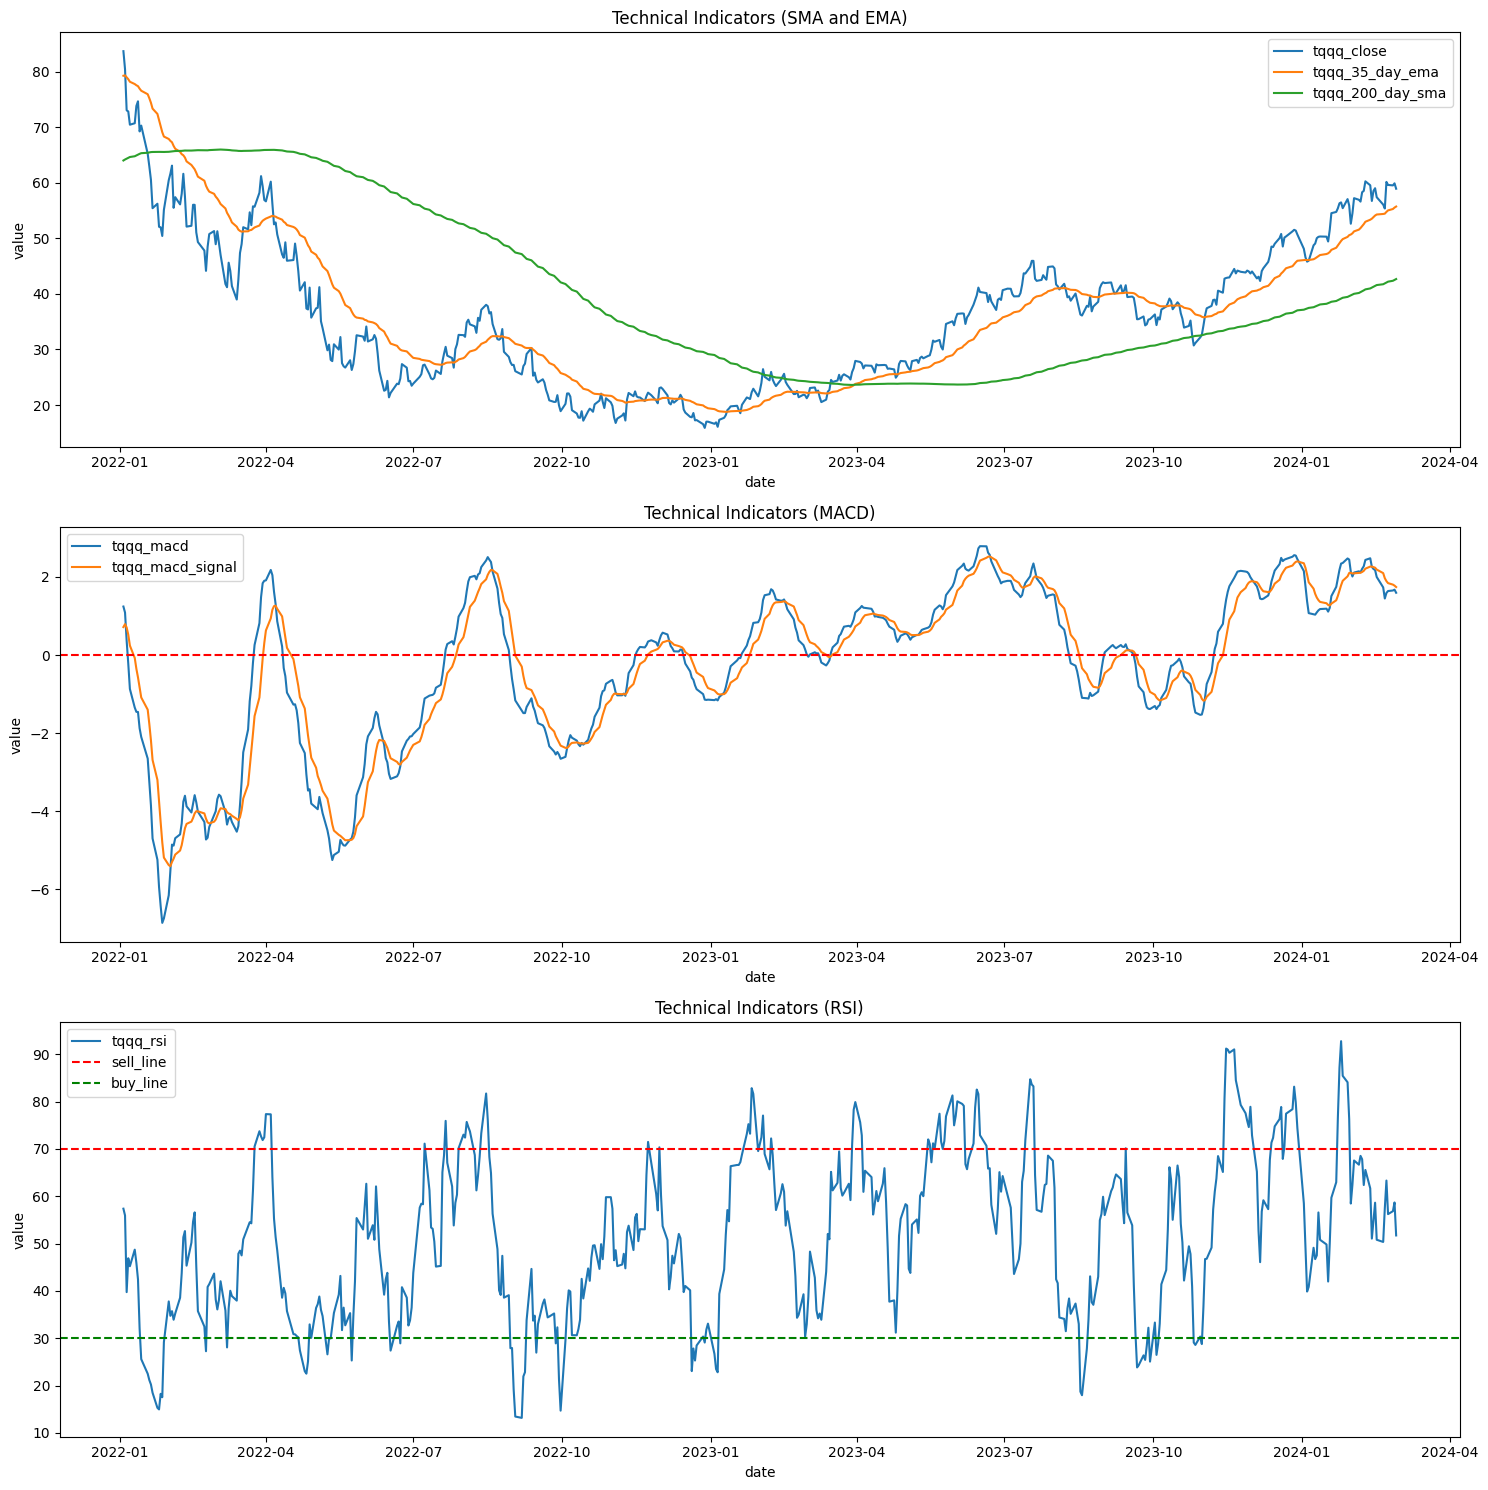

In [7]:
# plotting technical indicators
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].plot(df[df.Date > '2022-01-01'].Date, df[df.Date > '2022-01-01'].tqqq_close, label=df.tqqq_close.name)
axes[0].plot(df[df.Date > '2022-01-01'].Date, df[df.Date > '2022-01-01'].tqqq_35_day_ema, label=df.tqqq_35_day_ema.name)
axes[0].plot(df[df.Date > '2022-01-01'].Date, df[df.Date > '2022-01-01'].tqqq_200_day_sma, label=df.tqqq_200_day_sma.name)
axes[0].legend()
axes[0].set_title('Technical Indicators (SMA and EMA)')
axes[0].set_ylabel('value')
axes[0].set_xlabel('date')

axes[1].plot(df[df.Date > '2022-01-01'].Date, df[df.Date > '2022-01-01'].tqqq_macd, label=df.tqqq_macd.name)
axes[1].plot(df[df.Date > '2022-01-01'].Date, df[df.Date > '2022-01-01'].tqqq_macd_signal, label=df.tqqq_macd_signal.name)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].legend()
axes[1].set_title('Technical Indicators (MACD)')
axes[1].set_ylabel('value')
axes[1].set_xlabel('date')

axes[2].plot(df[df.Date > '2022-01-01'].Date, df[df.Date > '2022-01-01'].tqqq_rsi, label=df.tqqq_rsi.name)
axes[2].axhline(y=70, color='r', linestyle='--', label='sell_line')
axes[2].axhline(y=30, color='g', linestyle='--', label='buy_line')
axes[2].legend()
axes[2].set_title('Technical Indicators (RSI)')
axes[2].set_ylabel('value')
axes[2].set_xlabel('date')

plt.tight_layout()
plt.show()


### Observations

According to industry, we can make some assumptions about how these indicators work to signal an investor on shifts in momentum. 

The first chart shows the 35 day exponential moving average (EMA) and the 200 day simple moving average (SMA). According to experts, when the the EMA is above the SMA, then we can expect that the market will be trending upwards and visa-versa. Industry experts also determine that the EMA acts as either a support, where the price movement does not go below the EMA line and continues to trend upwards, or a resistor where the price movement will not go above the EMA line and trend downwards. Where as the SMA is identified as the primary trend setter, which means that the direction of the SMA, and whether it converges the EMA, will determine overall price movements.

https://www.investopedia.com/ask/answers/difference-between-simple-exponential-moving-average/#:~:text=Traders%20use%20many%20technical%20indicators,higher%20weighting%20to%20recent%20prices.

The second chart displays the Moving Average Convergence Divergence. This indicator uses two measures, the MACD and the MACD Signal, to determine when prices are essentially too high or too low using points that osccilate between positive and negative values. When the MACD is greater than the MACD Signal and also above 0, it signals to the investor towards a buying opportunity and visa-versa for a selling signal.

https://www.investopedia.com/terms/m/macd.asp

The last chart, Relative Strength Index (RSI), indicates momentum in the markets. This is used to determine at what point a security might be over bought or oversold. This is done by measuring the speed and magnitued of the changes in security pricing. When the momentum indicator is above 70, it indicates over buying and usually leads to a following decrease in price. When it is below 30 it indicates overselling and leads to a following increase in price. 

https://www.investopedia.com/terms/r/rsi.asp

## Additional Exploratory Data Analysis

Conducting more exploratory analysis on the current data

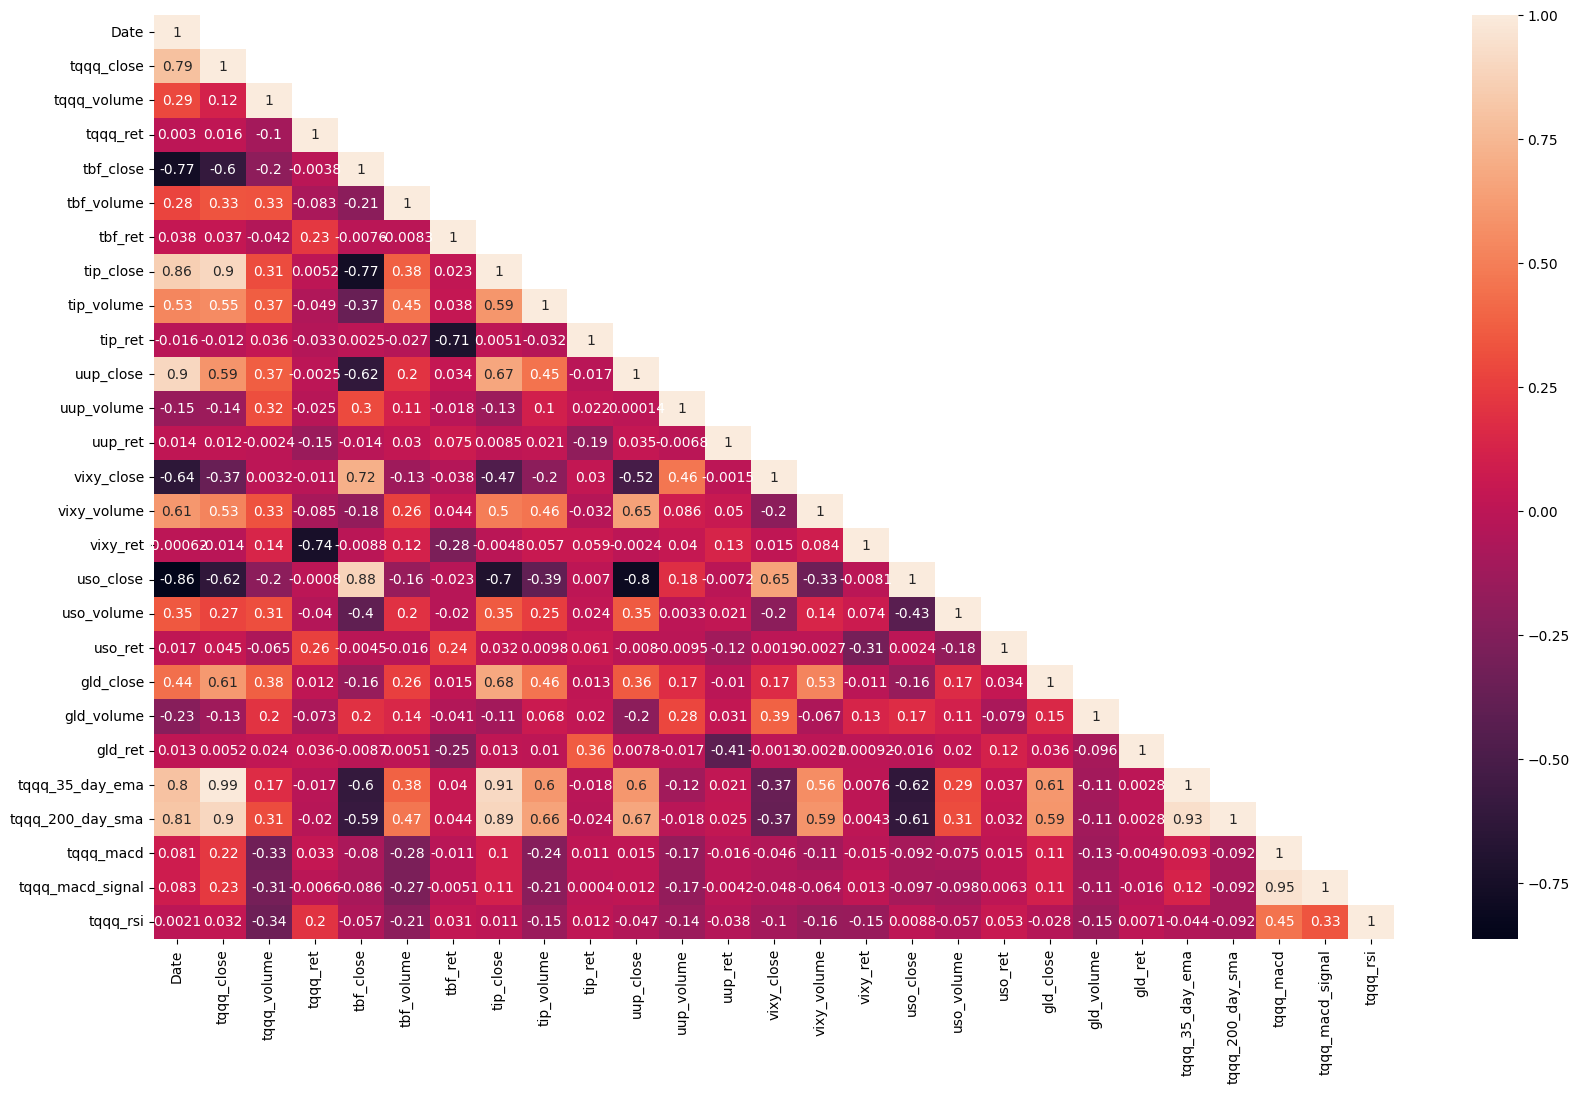

In [8]:
df_corr = df.corr()
mask = np.tril(np.ones(df_corr.shape), k=0).astype(bool)
df_corr_tril = df_corr.where(mask)

plt.figure(figsize=(20, 12))
sns.heatmap(df_corr_tril, annot=True)
plt.show()

### Observations

Although we do have correlations between some features of our data, each feature does maintain some importance due to the methodologies underlying their purpose. We will retain these highly correlated features for now. However, if the model performance is poor, we may attempt to remove the highly correlated features to research the impact on performance. 

## Buy / Sell Simulation

In the case where we conduct a supervised vs unsupervised model, we will simulate an environment of buy and sell decisions knowing what the future return is. We will conduct a simulation of buy and sell holding decisions for 1, 3, 5, 10, and 20 day buy and sell decisions. These decisions will essentially allow us to determine which holding strategy might work best. For example if we receive a greater return with the 1 day buy/sell decision vs the 3, 5, 10, or 20, then we will execute this strategy for that day. However, if the 10 day buy/sell decision leads to greater return then the others, we will execute this strategy until the 10 days have passed and on the 10th day we will re-evaluate the decisions again. One the day of decision we will label it as a buy, if we decision on longer than 1 day buy/sell then we will label as hold for those days in between. If each buy/sell decision (1, 3, 5, 10, and 20) yields a negative return, then we will decision a sell (short) and use the most negative buy/sell hold decision to execute.

Implementing this strategy will yield the greatest returns and allow us to have a dependent variable: **"decision"**

In [22]:
df['decision'] = ''
df['cash'] = df['tqqq_close'][0]
df['cash_ret'] = df['tqqq_ret'][0]
df['initial_hold_days'] = 1
df['hold_countdown'] = 1
days_to_hold = 0
hold_type = 'long'

for idx in range(len(df)):
    if idx == 0:
        # decision day 0 as long as entry into the market
        df['decision'][idx] = 'long'

    elif (idx < len(df)-20) & (idx != 0):

        # reaching the end of the days_to_hold, trigger new hold_dict with future returns
        if days_to_hold <= 1:
        
            # determine how many days to hold for greatest return
            hold_dict = {
                1: (df['tqqq_close'][idx+1]/df['tqqq_close'][idx])-1,
                3: (df['tqqq_close'][idx+3]/df['tqqq_close'][idx])-1,
                5: (df['tqqq_close'][idx+5]/df['tqqq_close'][idx])-1,
                10: (df['tqqq_close'][idx+10]/df['tqqq_close'][idx])-1,
                20: (df['tqqq_close'][idx+20]/df['tqqq_close'][idx])-1
            }

            # if all future values are negative, short the stock
            if all(value < 0 for value in hold_dict.values()):

                # when the initial position is a short, finish the current day as short
                if hold_type == 'short':
                    
                    df['decision'][idx] = 'short'
                    days_to_hold = min(hold_dict, key=hold_dict.get)
                    df['initial_hold_days'][idx] = days_to_hold
                    df['hold_countdown'][idx] = days_to_hold
                    df['cash'][idx] = df['cash'][idx-1]*(1+(df['tqqq_ret'][idx]*-1))
                    df['cash_ret'][idx] = (df['cash'][idx]/df['cash'][idx-1])-1
                    hold_type = 'short'

                # when the initial position is a long, finish the current day as long
                elif hold_type == 'long':

                    df['decision'][idx] = 'short'
                    days_to_hold = min(hold_dict, key=hold_dict.get)
                    df['initial_hold_days'][idx] = days_to_hold
                    df['hold_countdown'][idx] = days_to_hold
                    df['cash'][idx] = df['cash'][idx-1]*(1+(df['tqqq_ret'][idx]))
                    df['cash_ret'][idx] = (df['cash'][idx]/df['cash'][idx-1])-1
                    hold_type = 'short'

            else:

                # go long otherwise
                if hold_type == 'short':
                    # when the initial position is a short, finish the current day as short
                    df['decision'][idx] = 'long'
                    days_to_hold = max(hold_dict, key=hold_dict.get)
                    df['initial_hold_days'][idx] = days_to_hold
                    df['hold_countdown'][idx] = days_to_hold
                    df['cash'][idx] = df['cash'][idx-1]*(1+(df['tqqq_ret'][idx]*-1))
                    df['cash_ret'][idx] = (df['cash'][idx]/df['cash'][idx-1])-1
                    hold_type = 'long'
                
                elif hold_type == 'long':
                    # when the initial position is a long, finish the current day as long
                    df['decision'][idx] = 'long'
                    days_to_hold = max(hold_dict, key=hold_dict.get)
                    df['initial_hold_days'][idx] = days_to_hold
                    df['hold_countdown'][idx] = days_to_hold
                    df['cash'][idx] = df['cash'][idx-1]*(1+(df['tqqq_ret'][idx]))
                    df['cash_ret'][idx] = (df['cash'][idx]/df['cash'][idx-1])-1
                    hold_type = 'long'

        elif days_to_hold > 1:

            # when a days_to_hold is decided - continue position until end of the hold days
            if hold_type == 'long':
                df['decision'][idx] = 'hold'
                df['cash'][idx] = df['cash'][idx-1]*(1+df['tqqq_ret'][idx])
                df['cash_ret'][idx] = (df['cash'][idx]/df['cash'][idx-1])-1
                days_to_hold -= 1
                df['hold_countdown'][idx] = days_to_hold
                df['initial_hold_days'][idx] = df['initial_hold_days'][idx-1]
                
            elif hold_type == 'short':
                df['decision'][idx] = 'hold'
                df['cash'][idx] = df['cash'][idx-1]*(1+(df['tqqq_ret'][idx]*-1)) 
                df['cash_ret'][idx] = (df['cash'][idx]/df['cash'][idx-1])-1
                days_to_hold -= 1
                df['hold_countdown'][idx] = days_to_hold
                df['initial_hold_days'][idx] = df['initial_hold_days'][idx-1]

    else:
        # when we get to the end of our dataframe hold our current position (long/short)
        if hold_type == 'long':
            df['decision'][idx] = 'hold'
            df['cash'][idx] = df['cash'][idx-1]*(1+df['tqqq_ret'][idx])
            df['cash_ret'][idx] = (df['cash'][idx]/df['cash'][idx-1])-1
            df['hold_countdown'][idx] = 0
            df['initial_hold_days'][idx] = df['initial_hold_days'][idx-1]
            
        elif hold_type == 'short':
            df['decision'][idx] = 'hold'
            df['cash'][idx] = df['cash'][idx-1]*(1+(df['tqqq_ret'][idx]*-1))
            df['cash_ret'][idx] = (df['cash'][idx]/df['cash'][idx-1])-1
            df['hold_countdown'][idx] = 0
            df['initial_hold_days'][idx] = df['initial_hold_days'][idx-1]



In [23]:
# 60 day snapshot to confirm the investment decisions are working properly
df[['tqqq_ret', 'tqqq_close', 'decision', 'cash', 'cash_ret', 'initial_hold_days', 'hold_countdown']].iloc[0:60, :]

,tqqq_ret,tqqq_close,decision,cash,cash_ret,initial_hold_days,hold_countdown
0,-0.001553,0.784261,long,0.784261,-0.001553,1,1
1,0.024819,0.803726,long,0.803726,0.024819,20,20
2,0.009042,0.810993,hold,0.810993,0.009042,20,19
3,-0.002319,0.809113,hold,0.809113,-0.002319,20,18
4,0.011243,0.818210,hold,0.818210,0.011243,20,17
5,0.004596,0.821970,hold,0.821970,0.004596,20,16
6,0.020279,0.838639,hold,0.838639,0.020279,20,15
7,0.003152,0.841282,hold,0.841282,0.003152,20,14
8,0.021686,0.859526,hold,0.859526,0.021686,20,13
9,0.007983,0.866388,hold,0.866388,0.007983,20,12


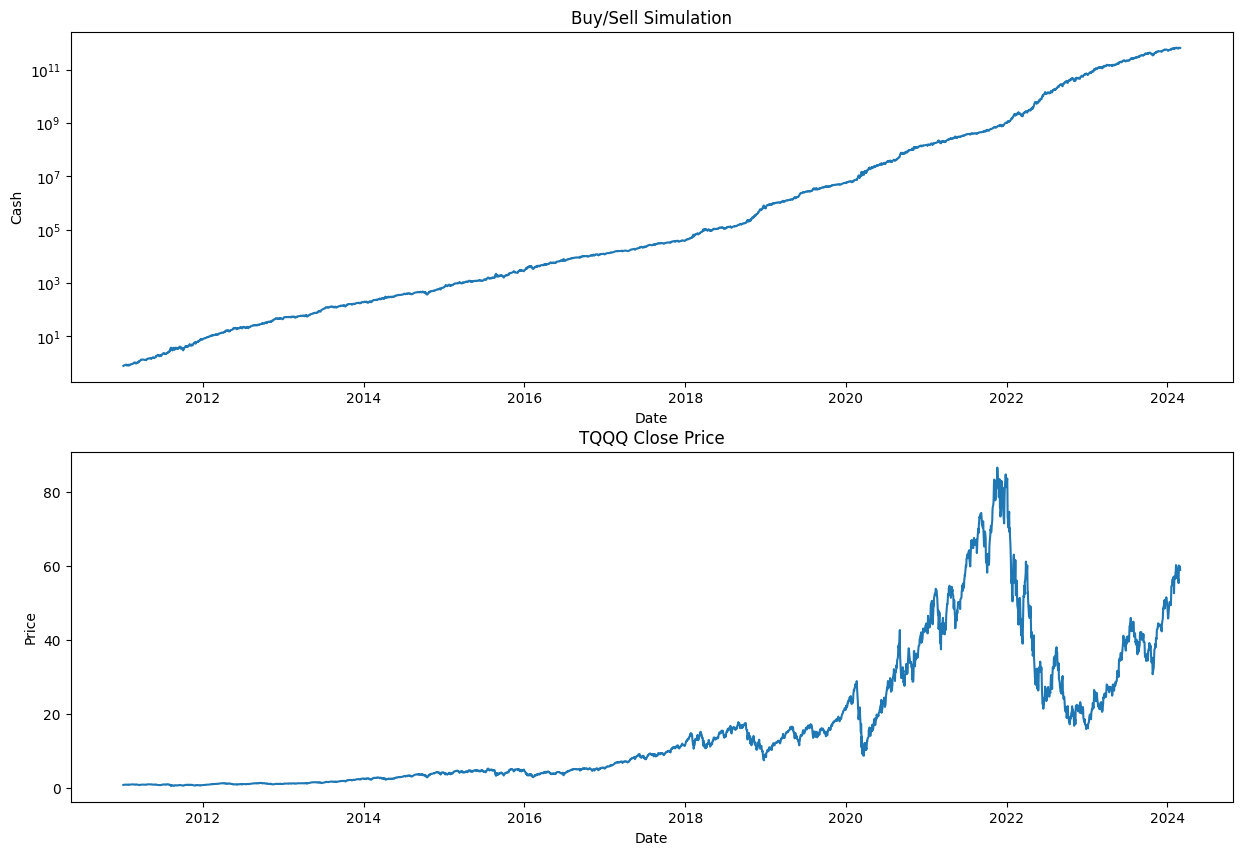

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
axes[0].plot(
    df['Date'],
    df['cash'],
    label='cash'
)
axes[0].set_yscale('log')
axes[0].set_title('Buy/Sell Simulation')
axes[0].set_ylabel('Cash')
axes[0].set_xlabel('Date')

axes[1].plot(
    df['Date'],
    df['tqqq_close'],
    label='tqqq'
)
axes[1].set_title('TQQQ Close Price')
axes[1].set_ylabel('Price')
axes[1].set_xlabel('Date')

plt.show()